In [10]:
def build_portfolio_pipeline():
    """Run the original notebook logic and expose two globals:
       ─ stock_prices     – NOK-converted price DataFrame
       ─ portfolio_values – portfolio-value Series/DataFrame
    """
    global stock_prices, portfolio_values

    # ───────────────────────────────────────── imports
    import pandas as pd
    import numpy as np
    import yfinance as yf
    from datetime import datetime
    from scipy.stats import skew, kurtosis
    import matplotlib.pyplot as plt

    # ───────────────────────────────────────── configuration
    start_date = "2024-06-09"
    end_date   = "2025-06-09"
    position_file = "Positions-19.12.24.csv"

    # ─────────────────────────────────────────  Load Data

    # Load & clean portfolio --------------------------------------------------
    def load_portfolio(filename):
        df = pd.read_csv(filename, encoding="utf-16", delimiter="\t",
                         on_bad_lines='skip')
        df.rename(columns={
            'Navn'       : 'Name',
            'Valuta'     : 'Currency',
            'Antall'     : 'Quantity',
            'Siste kurs' : 'LastPrice'
        }, inplace=True)
        df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
        return df

    # Map ”Name” → ticker (your exact dictionary) -----------------------------
    def map_tickers(df):
        name_to_ticker = {
            "Lvmh Moet Hennessy Vuitton SE": "MC.PA",
            "Microsoft": "MSFT",
            "Hennes & Mauritz AB, H & M ser. B": "HM-B.ST",
            "HYDROGENPRO ASA": "HYPRO.OL",
            "MPC CONTAINER SHIPS": "MPCC.OL",
            "ServiceNow": "NOW",
            "Linde": "LIN",
            "Waste Management": "WM",
            "Taiwan Semiconductor Manufacturing ADR": "TSM",
            "iShares Gold Trust Shares of the iShares Gold Trust": "IAU",
            "Nordnet AB": "SAVE.ST",
            "PEXIP HOLDING": "PEXIP.OL",
            "DnB NOR OBX": "DNB.OL",
            "Amazon.com": "AMZN",
            "ASML Holding": "ASML",
            "BlackRock": "BLK",
            "iShares 20+ Year Treasury Bond ETF": "TLT",
            "Walmart": "WMT",
            "ProShares UltraPro Short QQQ": "SQQQ",
            "NORDIC SEMICONDUCTOR": "NOD.OL",
            "EQUINOR ASA": "EQNR.OL",
            "AKER BP": "AKRBP.OL",
            "BORREGAARD": "BRG.OL",
            "TOMRA SYSTEMS": "TOM.OL",
            "KAHOOT!": "KAHOT.OL",
            "SCATEC": "SCATC.OL",
            "VEIDEKKE": "VEI.OL",
            "AKERHANSEN & AXCR": "AHA.OL",
            "VOLUE ASA": "VOLUE.OL",
            "ENCE Energy": "ENCE.MC",
            "GJENSIDIGE FORSIKRING": "GJF.OL",
            "ORKLA": "ORK.OL",
            "KONGSBERG GRUPPEN": "KOG.OL",
            "YARA INTERNATIONAL": "YAR.OL",
            "DNB": "DNB.OL",
            "AKER SOLUTIONS": "AKSO.OL",
            "HydrogenPro": "HYPRO.OL",
            "NORWEGIAN AIR SHUTTLE": "NAS.OL",
            "PROTECTOR FORSIKRING": "PROT.OL",
            "HOEGH AUTOLINERS ASA": "HAUTO.OL",
            "KLAVENESS COMBINATION CARRIERS": "KCC.OL",
            "MOWI": "MOWI.OL",
            "SELVAAG BOLIG": "SBO.OL",
            "Sleep Cycle AB": "SLEEP.ST",
            "SALMON EVOLUTION ASA": "SALME.OL",
            "Advanced Micro Devices": "AMD",
            "NVIDIA": "NVDA",
            "Vanguard Financials ETF": "VFH",
            "EUROPRIS": "EPRO.XC"
        }
        df['Ticker'] = df['Name'].map(name_to_ticker)
        return df.dropna(subset=['Ticker'])

    # Download prices ---------------------------------------------------------
    def get_prices(tickers, start, end):
        data = yf.download(tickers, start=start, end=end)

        # ‘Adj Close’ layer if present
        if isinstance(data.columns, pd.MultiIndex) and \
           'Adj Close' in data.columns.levels[0]:
            data = data['Adj Close']

        # Handle single-ticker result
        if isinstance(data, pd.Series):
            data = data.to_frame()

        # Replace zeros, align to business days, ffill
        data = data.mask(data == 0)
        data = data.reindex(pd.date_range(start, end, freq='B')).ffill()
        return data

    # Download FX rates -------------------------------------------------------
    def get_fx_rates(start, end):
        fx_tickers = {'EUR':'EURNOK=X', 'USD':'USDNOK=X', 'SEK':'SEKNOK=X'}
        raw = yf.download(list(fx_tickers.values()), start=start, end=end)

        if isinstance(raw.columns, pd.MultiIndex):
            fx = raw['Adj Close'] if 'Adj Close' in raw.columns.levels[0] \
                 else raw['Close']
        else:
            fx = raw
        fx = fx.rename(columns={v:k for k,v in fx_tickers.items()})
        fx = fx.mask(fx == 0)
        fx = fx.reindex(pd.date_range(start, end, freq='B')).ffill().bfill()
        return fx

    # NOK conversion ----------------------------------------------------------
    def convert_prices_to_nok(price_df, meta_df, fx_rates,
                              ticker_col='Ticker', ccy_col='Currency'):
        ticker_ccy = meta_df.set_index(ticker_col)[ccy_col]

        def _ticker(label):
            if isinstance(label, tuple):
                return label[-1]
            if isinstance(label, str) and '_' in label:
                return label.split('_')[-1]
            return label

        multiplier_df = pd.concat(
            {col: (pd.Series(1.0, index=price_df.index)
                   if ticker_ccy.get(_ticker(col), 'NOK') == 'NOK'
                   else fx_rates[ticker_ccy[_ticker(col)]])
             for col in price_df.columns},
            axis=1
        )
        return price_df * multiplier_df

    # ───────────────────────────────────────── pipeline

    portfolio_df = map_tickers(load_portfolio(position_file))
    tickers      = portfolio_df['Ticker'].tolist()

    price_df   = get_prices(tickers, start_date, end_date)
    fx_rates   = get_fx_rates(start_date, end_date)
    price_df_nok = convert_prices_to_nok(price_df, portfolio_df, fx_rates)

    if isinstance(price_df_nok.columns, pd.MultiIndex):
        price_df_nok = price_df_nok['Close']
    price_df_nok.columns = price_df_nok.columns.astype(str).str.strip()
    portfolio_df['Ticker'] = portfolio_df['Ticker'].astype(str).str.strip()

    weights         = portfolio_df.set_index('Ticker')['Quantity']
    common_tickers  = price_df_nok.columns.intersection(weights.index)
    aligned_prices  = price_df_nok[common_tickers]
    aligned_weights = weights.loc[common_tickers]

    portfolio_value_nok = (aligned_prices * aligned_weights).sum(axis=1)
    portfolio_value_nok.name = "Portfolio Value (NOK)"
    portfolio_value_nok.index.name = "Date"
    portfolio_value_nok = portfolio_value_nok.reset_index().set_index("Date")

    # (optional plot & diagnostic print—both were in your notebook)
    #print("Common tickers:", list(common_tickers))
    print("Portfolio value preview:")
    print(portfolio_value_nok.head())
    plt.plot(portfolio_value_nok)

    # ───────────────────────────────────────── expose results
    stock_prices     = price_df_nok
    portfolio_values = portfolio_value_nok


[*********************100%***********************]  30 of 30 completed
[*********************100%***********************]  3 of 3 completed


✅ Common tickers: ['AMD', 'AMZN', 'ASML', 'BLK', 'DNB.OL', 'EPRO.XC', 'HAUTO.OL', 'HM-B.ST', 'HYPRO.OL', 'IAU', 'KCC.OL', 'LIN', 'MC.PA', 'MOWI.OL', 'MPCC.OL', 'MSFT', 'NOW', 'NVDA', 'PEXIP.OL', 'PROT.OL', 'SALME.OL', 'SAVE.ST', 'SBO.OL', 'SLEEP.ST', 'SQQQ', 'TLT', 'TSM', 'VFH', 'WM', 'WMT']
📊 Portfolio value preview:
            Portfolio Value (NOK)
Date                             
2024-06-10          688371.404395
2024-06-11          685364.721432
2024-06-12          694102.686512
2024-06-13          688496.387346
2024-06-14          693658.124945


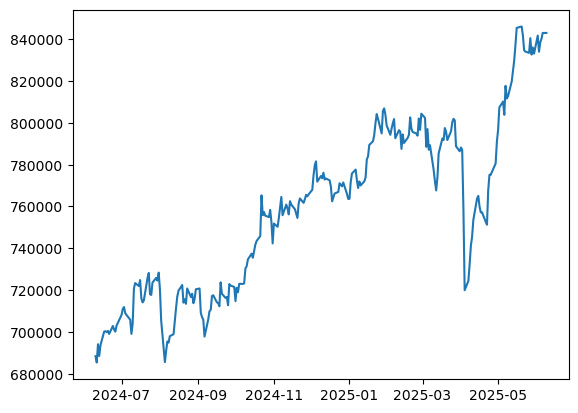

In [30]:
build_portfolio_pipeline()   # one-liner to reproduce workflow
     

C:\Users\A2410649\AppData\Local\Temp\ipykernel_13372\460251396.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_val_nok = float(portfolio_values.loc[ret_df.index[-1]])


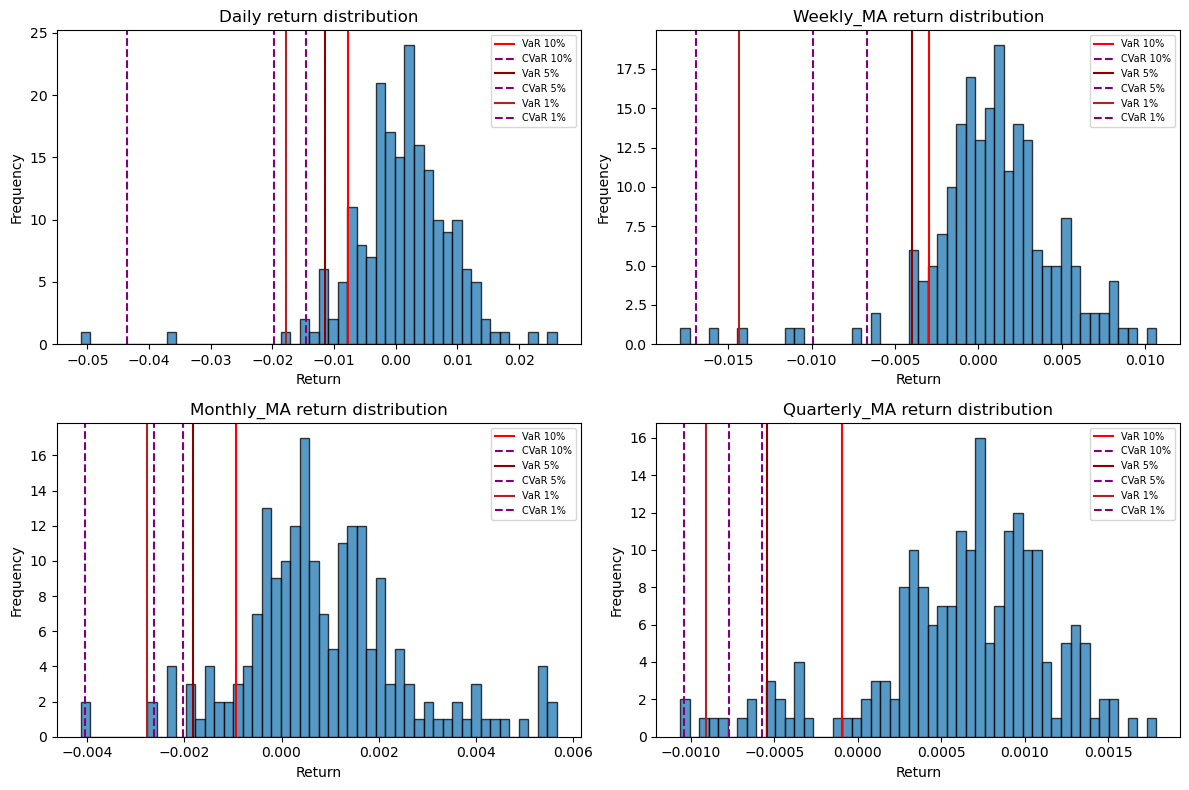


Mean and Standard Deviation


,Daily,Weekly_MA,Monthly_MA,Quarterly_MA
Mean,0.0924%,0.0851%,0.0854%,0.0624%
StdDev,0.8384%,0.3914%,0.1697%,0.0538%


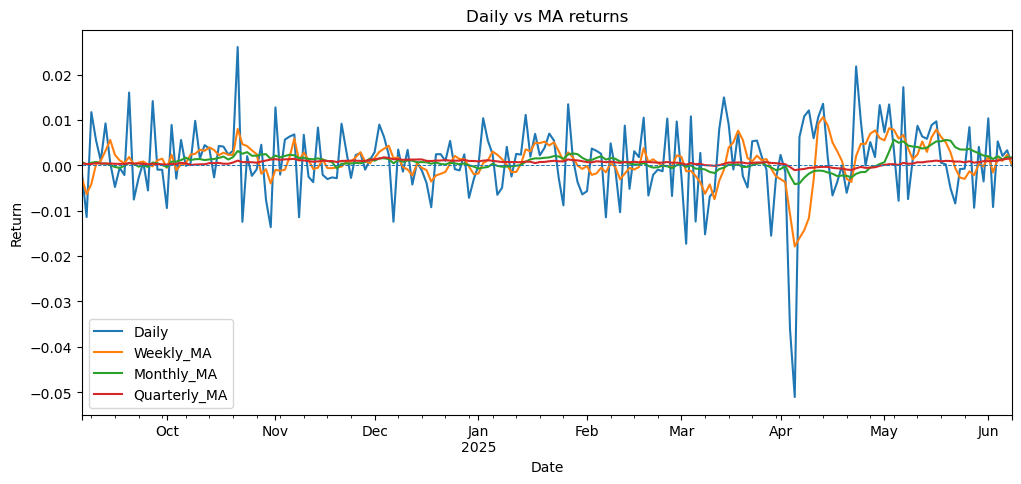

Skewness and Kurtosis
Daily           Skew =  -1.462    Kurtosis =  11.233
Weekly_MA       Skew =  -1.224    Kurtosis =   7.840
Monthly_MA      Skew =   0.402    Kurtosis =   4.009
Quarterly_MA    Skew =  -0.909    Kurtosis =   3.910

Historical VaR / CVaR  (positive = loss)


In [31]:
######## Risk and Retun Metrices for Portfolio###################################3
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# ─── 1. daily % return of the portfolio ──────────────────────────────────────
daily_ret = portfolio_values.squeeze().pct_change().dropna()

# ─── 2. moving-average daily returns ─────────────────────────────────────────
WINDOWS = {"Weekly_MA": 5, "Monthly_MA": 21, "Quarterly_MA": 63}
ma_series = {n: daily_ret.rolling(w, min_periods=w).mean() for n, w in WINDOWS.items()}

# ─── 3. combine for convenience ──────────────────────────────────────────────
ret_df = pd.concat([daily_ret.rename("Daily")] +
                   [s.rename(k) for k, s in ma_series.items()], axis=1).dropna()

# helper to fetch latest NOK portfolio value aligned to ret_df
latest_val_nok = float(portfolio_values.loc[ret_df.index[-1]])

# ---------------------------------------------------------------------------
# histograms with VaR / CVaR overlays  (unchanged)
# ---------------------------------------------------------------------------
def vartail(series, alpha):
    q = series.quantile(alpha)
    es = series[series <= q].mean()
    return q, es

LEVELS = [0.10, 0.05, 0.01]
COLOR  = {0.10: "red", 0.05: "darkred", 0.01: "firebrick"}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, col in zip(axes.flatten(), ret_df.columns):
    ax.hist(ret_df[col], bins=50, edgecolor="black", alpha=0.75)
    ax.set_title(f"{col} return distribution")
    ax.set_xlabel("Return"); ax.set_ylabel("Frequency")
    for a in LEVELS:
        v, c = vartail(ret_df[col], a)
        ax.axvline(v, color=COLOR[a],  linestyle="-",  label=f"VaR {int(a*100)}%")
        ax.axvline(c, color="purple", linestyle="--", label=f"CVaR {int(a*100)}%")
    ax.legend(fontsize=7)
plt.tight_layout(); plt.show()

# ---------------------------------------------------------------------------
# mean & std-dev table
# ---------------------------------------------------------------------------
mean_std_tbl = pd.DataFrame({"Mean": ret_df.mean(), "StdDev": ret_df.std()}).T
print("\nMean and Standard Deviation")
display(mean_std_tbl.style.format("{:.4%}"))

# ---------------------------------------------------------------------------
# time-series overlay
# ---------------------------------------------------------------------------
ret_df.plot(figsize=(12, 5), title="Daily vs MA returns")
plt.ylabel("Return"); plt.axhline(0, lw=0.7, ls="--"); plt.show()

# ---------------------------------------------------------------------------
# skew & kurtosis print-out
# ---------------------------------------------------------------------------
print("Skewness and Kurtosis")
for col in ret_df.columns:
    print(f"{col:<14}  Skew = {skew(ret_df[col]):7.3f}    "
          f"Kurtosis = {kurtosis(ret_df[col], fisher=False):7.3f}")

# ---------------------------------------------------------------------------
#  VaR & CVaR table — % and NOK
# ---------------------------------------------------------------------------
def var_pct(series, alpha):   return -series.quantile(alpha)
def cvar_pct(series, alpha):
    cutoff = series.quantile(alpha)
    return -series[series <= cutoff].mean()

records = []
for s in ret_df.columns:
    for a in LEVELS:
        v_pct  = var_pct (ret_df[s], a)
        cv_pct = cvar_pct(ret_df[s], a)
        records.append({
            "Series"     : s,
            "Level"      : f"{int(a*100)} %",
            "VaR %"      : v_pct,
            "CVaR %"     : cv_pct,
            "VaR NOK"    : v_pct  * latest_val_nok,
            "CVaR NOK"   : cv_pct * latest_val_nok
        })

risk_tbl = (pd.DataFrame(records)
              .set_index(["Series", "Level"])
              .sort_index())

print("\nHistorical VaR / CVaR  (positive = loss)")
display(risk_tbl.style.format({
    "VaR %"    : "{:.2%}",
    "CVaR %"   : "{:.2%}",
    "VaR NOK"  : "{:,.0f}",
    "CVaR NOK" : "{:,.0f}"
}))


In [32]:
######### Metrices for Stocks ##############################
# ─────────────────────────────────────────────────────────────
# 1. daily % returns for every asset
# ─────────────────────────────────────────────────────────────
asset_ret = stock_prices.pct_change().dropna()

# ─────────────────────────────────────────────────────────────
# 2. summary statistics table
# ─────────────────────────────────────────────────────────────
stats_df = pd.DataFrame({
    "Mean"     : asset_ret.mean(),
    "StdDev"   : asset_ret.std(),
    "Variance" : asset_ret.var(),
    "Skew"     : asset_ret.apply(skew),
    "Kurtosis" : asset_ret.apply(kurtosis)
})

# ─── optional: order rows by mean return (highest first) ───
stats_df = stats_df.sort_values("Mean", ascending=False)

# ─────────────────────────────────────────────────────────────
# 3. style: {largest ↦ red, smallest ↦ blue} per column
# ─────────────────────────────────────────────────────────────
styled_stats = (
    stats_df
      .style
      .format("{:.2%}")                       # show as %
      .background_gradient(axis=0, cmap="coolwarm")  # red = high, blue = low
)

display(styled_stats)

# ─────────────────────────────────────────────────────────────
# 4. variance–covariance matrix
# ─────────────────────────────────────────────────────────────
cov_mat = asset_ret.cov()

styled_cov = (
    cov_mat
      .style
      .format("{:.4f}")
      .background_gradient(cmap="coolwarm")   # red = high covariance, blue = low
)

display(styled_cov)

,Mean,StdDev,Variance,Skew,Kurtosis
Ticker,,,,,
PEXIP.OL,0.33%,2.19%,0.05%,126.66%,822.04%
PROT.OL,0.22%,1.77%,0.03%,-89.38%,948.51%
NOW,0.16%,2.74%,0.08%,107.40%,910.76%
DNB.OL,0.15%,1.20%,0.01%,6.49%,662.64%
WMT,0.14%,1.61%,0.03%,39.71%,577.46%
IAU,0.12%,1.32%,0.02%,-3.85%,25.60%
NVDA,0.10%,3.70%,0.14%,-6.63%,370.18%
SAVE.ST,0.10%,1.80%,0.03%,7.13%,239.75%
TSM,0.10%,2.91%,0.08%,-16.51%,300.17%


Ticker,AMD,AMZN,ASML,BLK,DNB.OL,EPRO.XC,HAUTO.OL,HM-B.ST,HYPRO.OL,IAU,KCC.OL,LIN,MC.PA,MOWI.OL,MPCC.OL,MSFT,NOW,NVDA,PEXIP.OL,PROT.OL,SALME.OL,SAVE.ST,SBO.OL,SLEEP.ST,SQQQ,TLT,TSM,VFH,WM,WMT
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AMD,0.0011,0.0005,0.0007,0.0003,0.0000,0.0000,0.0001,0.0000,0.0001,0.0001,0.0001,0.0002,0.0001,0.0000,0.0002,0.0003,0.0005,0.0008,0.0001,0.0000,0.0000,0.0001,-0.0000,0.0000,-0.0012,0.0000,0.0007,0.0003,0.0001,0.0002
AMZN,0.0005,0.0005,0.0004,0.0003,0.0000,-0.0000,0.0001,0.0000,-0.0000,0.0001,0.0000,0.0001,0.0001,0.0000,0.0001,0.0003,0.0004,0.0005,0.0001,0.0000,0.0000,0.0001,-0.0000,0.0000,-0.0008,0.0000,0.0004,0.0002,0.0001,0.0002
ASML,0.0007,0.0004,0.0009,0.0002,0.0000,-0.0000,0.0001,0.0000,-0.0000,0.0001,0.0001,0.0002,0.0002,0.0000,0.0001,0.0003,0.0004,0.0007,0.0001,-0.0000,0.0000,0.0001,0.0000,0.0000,-0.0010,0.0000,0.0006,0.0002,0.0001,0.0001
BLK,0.0003,0.0003,0.0002,0.0003,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0000,0.0001,0.0001,0.0001,0.0001,0.0002,0.0003,0.0003,0.0001,0.0000,0.0000,0.0001,-0.0000,0.0000,-0.0005,0.0001,0.0003,0.0002,0.0001,0.0002
DNB.OL,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0001,0.0000,0.0000,0.0000,0.0001,0.0001,0.0001,0.0001,0.0000,0.0001,-0.0001,-0.0000,0.0000,0.0000,0.0000,0.0000
EPRO.XC,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0004,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000
HAUTO.OL,0.0001,0.0001,0.0001,0.0001,0.0001,0.0000,0.0007,0.0000,-0.0000,0.0000,0.0003,0.0000,0.0001,0.0000,0.0005,0.0000,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,-0.0001,-0.0000,0.0001,0.0001,0.0000,0.0000
HM-B.ST,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0003,0.0000,-0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,-0.0001,0.0000,0.0000,0.0000,-0.0000,0.0000
HYPRO.OL,0.0001,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0015,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0001,-0.0000,0.0001,0.0000,0.0000,0.0000,-0.0000,0.0001,-0.0002,-0.0000,0.0001,-0.0000,-0.0001,-0.0001


In [33]:
import pandas as pd
from scipy.stats import skew, kurtosis

# ---------------------------------------------------------------
# 1. daily % returns for every asset
# ---------------------------------------------------------------
asset_ret = stock_prices.pct_change().dropna()

# ---------------------------------------------------------------
# 2. per-asset summary stats
# ---------------------------------------------------------------
stats_df = pd.DataFrame({
    "Mean"     : asset_ret.mean(),
    "StdDev"   : asset_ret.std(),
    "Variance" : asset_ret.var(),
    "Skew"     : asset_ret.apply(skew),
    "Kurtosis" : asset_ret.apply(kurtosis)
}).sort_values("Mean", ascending=False)

# ---------------------------------------------------------------
# 3. column-wise formatting
#    • Mean / StdDev / Variance → % (or change Variance if you prefer)
#    • Skew / Kurtosis          → plain decimals
# ---------------------------------------------------------------
styled_stats = (
    stats_df
      .style
      .format({
          "Mean"    : "{:.2%}",
          "StdDev"  : "{:.2%}",
          "Variance": "{:.4%}",   # or "{:.6f}" if you want raw variance
          "Skew"    : "{:.3f}",
          "Kurtosis": "{:.3f}"
      })
      .background_gradient(axis=0, cmap="coolwarm")
)

display(styled_stats)

# ---------------------------------------------------------------
# 4. variance–covariance matrix (unchanged)
# ---------------------------------------------------------------
cov_mat = asset_ret.cov()
styled_cov = (
    cov_mat
      .style
      .format("{:.4f}")
      .background_gradient(cmap="coolwarm")
)

display(styled_cov)


,Mean,StdDev,Variance,Skew,Kurtosis
Ticker,,,,,
PEXIP.OL,0.33%,2.19%,0.0481%,1.267,8.220
PROT.OL,0.22%,1.77%,0.0312%,-0.894,9.485
NOW,0.16%,2.74%,0.0751%,1.074,9.108
DNB.OL,0.15%,1.20%,0.0145%,0.065,6.626
WMT,0.14%,1.61%,0.0259%,0.397,5.775
IAU,0.12%,1.32%,0.0173%,-0.039,0.256
NVDA,0.10%,3.70%,0.1366%,-0.066,3.702
SAVE.ST,0.10%,1.80%,0.0326%,0.071,2.398
TSM,0.10%,2.91%,0.0849%,-0.165,3.002


Ticker,AMD,AMZN,ASML,BLK,DNB.OL,EPRO.XC,HAUTO.OL,HM-B.ST,HYPRO.OL,IAU,KCC.OL,LIN,MC.PA,MOWI.OL,MPCC.OL,MSFT,NOW,NVDA,PEXIP.OL,PROT.OL,SALME.OL,SAVE.ST,SBO.OL,SLEEP.ST,SQQQ,TLT,TSM,VFH,WM,WMT
Ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AMD,0.0011,0.0005,0.0007,0.0003,0.0000,0.0000,0.0001,0.0000,0.0001,0.0001,0.0001,0.0002,0.0001,0.0000,0.0002,0.0003,0.0005,0.0008,0.0001,0.0000,0.0000,0.0001,-0.0000,0.0000,-0.0012,0.0000,0.0007,0.0003,0.0001,0.0002
AMZN,0.0005,0.0005,0.0004,0.0003,0.0000,-0.0000,0.0001,0.0000,-0.0000,0.0001,0.0000,0.0001,0.0001,0.0000,0.0001,0.0003,0.0004,0.0005,0.0001,0.0000,0.0000,0.0001,-0.0000,0.0000,-0.0008,0.0000,0.0004,0.0002,0.0001,0.0002
ASML,0.0007,0.0004,0.0009,0.0002,0.0000,-0.0000,0.0001,0.0000,-0.0000,0.0001,0.0001,0.0002,0.0002,0.0000,0.0001,0.0003,0.0004,0.0007,0.0001,-0.0000,0.0000,0.0001,0.0000,0.0000,-0.0010,0.0000,0.0006,0.0002,0.0001,0.0001
BLK,0.0003,0.0003,0.0002,0.0003,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0000,0.0001,0.0001,0.0001,0.0001,0.0002,0.0003,0.0003,0.0001,0.0000,0.0000,0.0001,-0.0000,0.0000,-0.0005,0.0001,0.0003,0.0002,0.0001,0.0002
DNB.OL,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0001,0.0001,0.0000,0.0000,0.0000,0.0001,0.0001,0.0001,0.0001,0.0000,0.0001,-0.0001,-0.0000,0.0000,0.0000,0.0000,0.0000
EPRO.XC,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0004,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000
HAUTO.OL,0.0001,0.0001,0.0001,0.0001,0.0001,0.0000,0.0007,0.0000,-0.0000,0.0000,0.0003,0.0000,0.0001,0.0000,0.0005,0.0000,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,-0.0001,-0.0000,0.0001,0.0001,0.0000,0.0000
HM-B.ST,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0003,0.0000,-0.0000,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,-0.0001,0.0000,0.0000,0.0000,-0.0000,0.0000
HYPRO.OL,0.0001,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0015,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0001,-0.0000,0.0001,0.0000,0.0000,0.0000,-0.0000,0.0001,-0.0002,-0.0000,0.0001,-0.0000,-0.0001,-0.0001


[*********************100%***********************]  1 of 1 completed

Batting average (portfolio beats S&P 500): 124 / 248 days (50.00%)


,Mean,StdDev,Skew,Kurtosis,VaR 10%,CVaR 10%,VaR 5%,CVaR 5%,VaR 1%,CVaR 1%
Series,,,,,,,,,,
Batting Average,50.00%,—,—,—,—,—,—,—,—,—
Portfolio Daily,0.09%,0.86%,-1.262,9.280,0.89%,1.56%,1.23%,2.04%,2.47%,3.85%
S&P 500 Daily,0.05%,1.25%,0.857,18.054,1.34%,2.26%,1.82%,2.89%,3.24%,4.76%


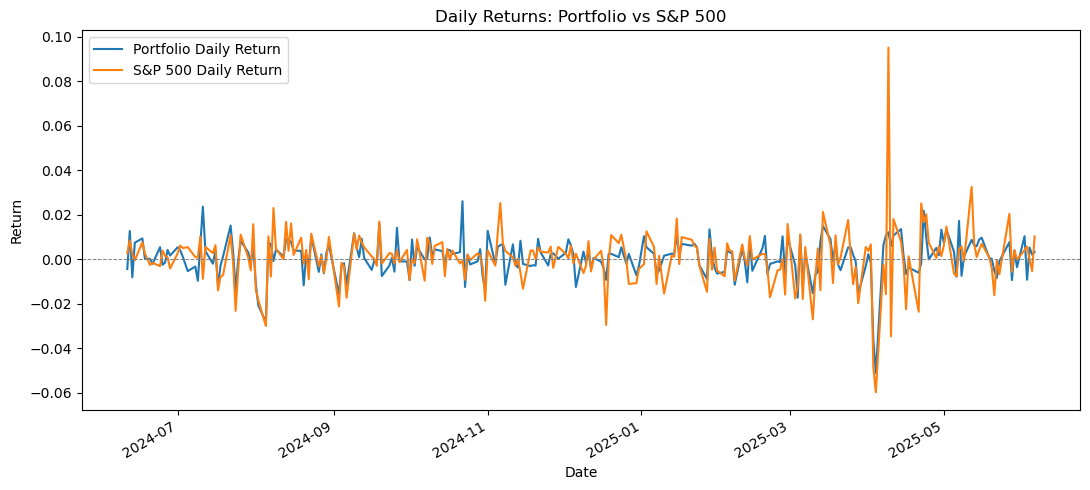

In [49]:
####### Benchmark Comparison#############
# We have taken S&P 500 as the benchmark.
import pandas as pd
import yfinance as yf
from datetime import timedelta

# --- parameters -------------------------------------------------------------
ticker = "^GSPC"                 # Yahoo Finance symbol for the S&P 500 index
start  = "2024-06-09"            # inclusive; set to whatever you need
end    = "2025-06-09"            # exclusive; None = up to today

# --- download (auto-adjust for dividends / splits) --------------------------
market = yf.download(ticker, start=start, end=end, auto_adjust=True)
market = market["Close"]

import pandas as pd
import numpy as np                      # NEW: for NaN
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# ─── 0. 1-D Series & align dates ────────────────────────────────────────────
port_val = (portfolio_values.iloc[:, 0]
            if isinstance(portfolio_values, pd.DataFrame)
            else portfolio_values.squeeze())
sp_lvl = (market.iloc[:, 0]
          if isinstance(market, pd.DataFrame)
          else market.squeeze())

port_val, sp_lvl = port_val.align(sp_lvl, join="inner")

# ─── 1. daily % returns ─────────────────────────────────────────────────────
port_ret = port_val.pct_change().dropna()
sp_ret   = sp_lvl.pct_change().dropna()
port_ret, sp_ret = port_ret.align(sp_ret, join="inner")

# ─── 2. batting average ─────────────────────────────────────────────────────
batting_days = (port_ret > sp_ret).sum()
batting_avg  = batting_days / len(port_ret)
print(f"Batting average (portfolio beats S&P 500): "
      f"{batting_days} / {len(port_ret)} days ({batting_avg:.2%})")

# ─── 3. VaR / CVaR helpers ──────────────────────────────────────────────────
def var(series, alpha):  return -series.quantile(alpha)
def cvar(series, alpha):
    q = series.quantile(alpha)
    return -series[series <= q].mean()

LEVELS = [0.10, 0.05, 0.01]

# ─── 4. risk-metric rows for daily returns ──────────────────────────────────
def make_row(label, ser):
    r = {"Mean": ser.mean(),
         "StdDev": ser.std(),
         "Skew": skew(ser),
         "Kurtosis": kurtosis(ser, fisher=False)}
    for a in LEVELS:
        p = int(a*100)
        r[f"VaR {p}%"]  = var (ser, a)
        r[f"CVaR {p}%"] = cvar(ser, a)
    r["Series"] = label
    return r

rows = [make_row("Portfolio Daily", port_ret),
        make_row("S&P 500 Daily",  sp_ret)]

# batting-average row: keep Mean numeric, others NaN
bat_row = {col: np.nan for col in rows[0].keys()}
bat_row.update({"Series": "Batting Average", "Mean": batting_avg})
rows.append(bat_row)

stats_df = pd.DataFrame(rows).set_index("Series").sort_index()

# ─── 5. formatting ──────────────────────────────────────────────────────────
fmt = {c: "{:.2%}" for c in stats_df.columns
        if any(k in c for k in ["Mean", "StdDev", "VaR", "CVaR"])}
fmt.update({"Skew": "{:.3f}", "Kurtosis": "{:.3f}"})

display(
    stats_df.style
            .format(fmt, na_rep="—")           # NaN → "—"
            .background_gradient(axis=0, cmap="coolwarm")
)

# ─── 6. plot daily returns ──────────────────────────────────────────────────
plt.figure(figsize=(11, 5))
port_ret.plot(label="Portfolio Daily Return")
sp_ret.plot(label="S&P 500 Daily Return")
plt.axhline(0, lw=0.7, ls="--", color="gray")
plt.title("Daily Returns: Portfolio vs S&P 500")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()
